In [85]:
# Importing the libraries
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Flatten,Dense,Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
import seaborn as sns

## Data Preprocessing



In [86]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/HackerEarth-Dance form Classification/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/HackerEarth-Dance form Classification/test.csv')

In [87]:
train.shape

(364, 2)

In [88]:
train.head(10)

,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi
5,46.jpg,kathak
6,326.jpg,sattriya
7,408.jpg,kuchipudi
8,365.jpg,sattriya
9,422.jpg,kuchipudi


In [89]:
test.head()

,Image
0,508.jpg
1,246.jpg
2,473.jpg
3,485.jpg
4,128.jpg


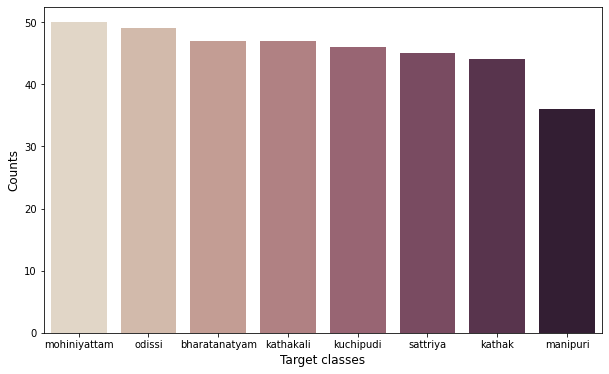

In [90]:
# Distribution of the target variable
target_count = train.target.value_counts()
plt.figure(figsize = (10,6))
sns.barplot(target_count.index, target_count.values, palette="ch:.25")
plt.xlabel('Target classes', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()


(183, 276, 3)


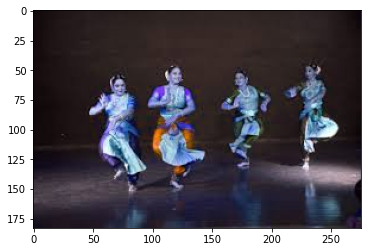

In [91]:
#Load the image data and visualise it USING Open CV.

TRAIN_PATH = '/content/drive/My Drive/Colab Notebooks/HackerEarth-Dance form Classification/train'
TEST_PATH = '/content/drive/My Drive/Colab Notebooks/HackerEarth-Dance form Classification/test'

import cv2 
img = cv2.imread(TRAIN_PATH + '/' + '163.jpg')
print(img.shape)
plt.imshow(img)

In [167]:
#We create a function, which reads an image, resizes it to 128 x 128 dimensions and returns it.

def read_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    return img

from tqdm import tqdm 
train_img = []
for img_path in tqdm(train['Image'].values):
    train_img.append(read_img(TRAIN_PATH + '/' + img_path))

100%|██████████| 364/364 [00:02<00:00, 151.00it/s]


In [168]:
class_list = train['target'].tolist()
print(class_list)

['manipuri', 'bharatanatyam', 'odissi', 'kathakali', 'odissi', 'kathak', 'sattriya', 'kuchipudi', 'sattriya', 'kuchipudi', 'kuchipudi', 'kuchipudi', 'kathak', 'sattriya', 'kathakali', 'odissi', 'sattriya', 'kuchipudi', 'manipuri', 'kathak', 'manipuri', 'bharatanatyam', 'kuchipudi', 'kuchipudi', 'mohiniyattam', 'odissi', 'kathak', 'odissi', 'odissi', 'sattriya', 'kathakali', 'kathak', 'kathakali', 'sattriya', 'bharatanatyam', 'kathak', 'bharatanatyam', 'kathakali', 'odissi', 'odissi', 'odissi', 'kuchipudi', 'manipuri', 'mohiniyattam', 'mohiniyattam', 'odissi', 'kathak', 'manipuri', 'kathak', 'mohiniyattam', 'odissi', 'sattriya', 'sattriya', 'odissi', 'kuchipudi', 'sattriya', 'mohiniyattam', 'manipuri', 'sattriya', 'kathak', 'odissi', 'sattriya', 'manipuri', 'kathakali', 'sattriya', 'kathakali', 'manipuri', 'bharatanatyam', 'kathak', 'kathak', 'sattriya', 'bharatanatyam', 'kathakali', 'kathak', 'mohiniyattam', 'manipuri', 'kathak', 'kuchipudi', 'odissi', 'kuchipudi', 'bharatanatyam', 'ku

In [169]:
def display_pics(image_batch, label_batch):
  plt.figure(figsize=(12,12))
  for n in range(36):
    axis = plt.subplot(6, 6, n+1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].title(), fontsize = 8)
    plt.axis('off')

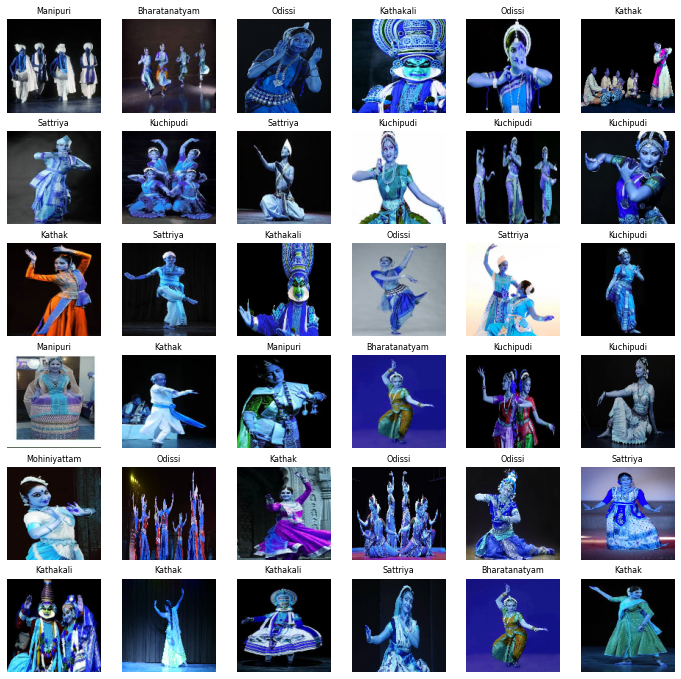

In [170]:
display_pics(train_img, class_list)

In [171]:
Y_train = {k:v+1 for v,k in enumerate(set(class_list))}
y_train = [Y_train[k] for k in class_list]
print(y_train)

#One-hot encoding the target variable.
from keras.utils import to_categorical
labels = to_categorical(y_train)
print(labels)

[8, 2, 4, 3, 4, 6, 1, 7, 1, 7, 7, 7, 6, 1, 3, 4, 1, 7, 8, 6, 8, 2, 7, 7, 5, 4, 6, 4, 4, 1, 3, 6, 3, 1, 2, 6, 2, 3, 4, 4, 4, 7, 8, 5, 5, 4, 6, 8, 6, 5, 4, 1, 1, 4, 7, 1, 5, 8, 1, 6, 4, 1, 8, 3, 1, 3, 8, 2, 6, 6, 1, 2, 3, 6, 5, 8, 6, 7, 4, 7, 2, 7, 2, 1, 6, 7, 5, 8, 5, 2, 4, 7, 4, 7, 2, 5, 2, 2, 1, 6, 3, 5, 1, 2, 4, 6, 1, 1, 7, 4, 6, 8, 3, 2, 5, 3, 7, 8, 5, 2, 5, 6, 3, 7, 2, 5, 2, 5, 3, 2, 5, 2, 8, 8, 1, 5, 1, 2, 4, 5, 4, 5, 3, 4, 1, 2, 5, 4, 1, 8, 1, 1, 6, 4, 3, 2, 5, 6, 7, 8, 1, 3, 5, 3, 6, 1, 5, 2, 2, 7, 4, 6, 4, 7, 5, 7, 4, 1, 2, 2, 3, 4, 5, 8, 4, 3, 5, 5, 7, 6, 5, 8, 4, 4, 7, 3, 2, 3, 5, 2, 3, 5, 4, 8, 7, 2, 1, 7, 3, 5, 3, 1, 5, 6, 7, 5, 7, 1, 5, 6, 5, 1, 4, 6, 6, 3, 5, 5, 1, 6, 2, 6, 8, 3, 1, 8, 7, 8, 6, 2, 6, 7, 3, 3, 4, 7, 2, 3, 7, 3, 4, 2, 1, 1, 6, 2, 4, 1, 2, 4, 1, 5, 3, 3, 7, 7, 4, 8, 4, 1, 6, 4, 8, 2, 7, 2, 1, 5, 8, 2, 3, 5, 2, 6, 3, 7, 2, 3, 5, 3, 7, 1, 1, 5, 3, 1, 1, 7, 8, 3, 8, 8, 3, 3, 5, 7, 4, 1, 2, 2, 6, 6, 7, 8, 3, 5, 3, 3, 7, 4, 4, 1, 8, 7, 4, 6, 3, 8, 3, 6, 2, 4, 2, 

In [172]:
labels = list(train['target'])
labels = np.array(labels)
lb = LabelEncoder()
labels = lb.fit_transform(labels)
print(labels[:10])
labels = to_categorical(labels)
print(labels[:10])

[4 0 6 2 6 1 7 3 7 3]
[[0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]


In [173]:
X_train, X_val, y_train, y_val = train_test_split(train_img, labels, test_size=0.2, random_state=42)

In [174]:
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))

291
291
73
73


In [175]:
# Image Augmentation on training set
train_datagen = ImageDataGenerator(
    rescale = 1./255, 
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = False, 
    dtype = 'float32')

val_datagen=ImageDataGenerator(rescale=1. / 255)

train_datagen.fit(X_train)
val_datagen.fit(X_val)
X_train=np.array(X_train)
X_val=np.array(X_val)

In [176]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(291, 128, 128, 3)
(291, 8)
(73, 128, 128, 3)
(73, 8)


## Building the model

In [177]:
from tensorflow.keras.applications.vgg16 import VGG16

In [178]:
vggmodel =VGG16(weights='imagenet', include_top=False, input_shape = (128, 128, 3),pooling='max')
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [219]:
vggmodel.trainable = False
model = Sequential([
  vggmodel, 
  Dense(1024, activation='relu'),
  Dropout(0.4),
  Dense(y_train.shape[1], activation='softmax'),
])

In [220]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_29 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_16 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 8200      
Total params: 15,248,200
Trainable params: 533,512
Non-trainable params: 14,714,688
_________________________________________________________________


In [221]:
model.compile( optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [222]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=3,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)

In [223]:
history =model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=val_datagen.flow(X_val, y_val, batch_size=32),
    verbose=2,
    epochs=100, 
    callbacks = [learning_rate_reduction]
)

Epoch 1/100
10/10 - 1s - loss: 2.5560 - accuracy: 0.1615 - val_loss: 2.0114 - val_accuracy: 0.3014 - lr: 0.0010
Epoch 2/100
10/10 - 1s - loss: 1.9247 - accuracy: 0.2749 - val_loss: 1.7565 - val_accuracy: 0.3973 - lr: 0.0010
Epoch 3/100
10/10 - 1s - loss: 1.6893 - accuracy: 0.4124 - val_loss: 1.3569 - val_accuracy: 0.5342 - lr: 0.0010
Epoch 4/100
10/10 - 1s - loss: 1.5528 - accuracy: 0.4021 - val_loss: 1.2847 - val_accuracy: 0.5616 - lr: 0.0010
Epoch 5/100
10/10 - 1s - loss: 1.3419 - accuracy: 0.5601 - val_loss: 1.1178 - val_accuracy: 0.6438 - lr: 0.0010
Epoch 6/100
10/10 - 1s - loss: 1.2321 - accuracy: 0.5567 - val_loss: 1.1768 - val_accuracy: 0.6438 - lr: 0.0010
Epoch 7/100
10/10 - 1s - loss: 1.1619 - accuracy: 0.5945 - val_loss: 1.0930 - val_accuracy: 0.6164 - lr: 0.0010
Epoch 8/100
10/10 - 1s - loss: 1.1777 - accuracy: 0.6014 - val_loss: 1.1605 - val_accuracy: 0.6575 - lr: 0.0010
Epoch 9/100
10/10 - 1s - loss: 1.0759 - accuracy: 0.6460 - val_loss: 1.4494 - val_accuracy: 0.5068 - lr:

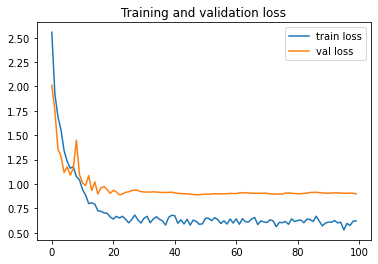

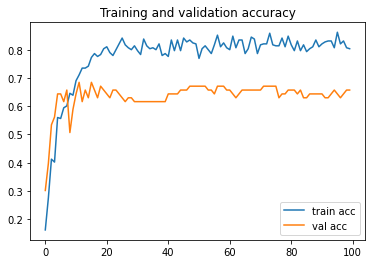

<Figure size 432x288 with 0 Axes>

In [224]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title ('Training and validation loss'   )
plt.show()

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Training and validation accuracy')
plt.show()
plt.savefig('AvvVal_acc1')

## Prediction

In [225]:
test.head()

,Image
0,508.jpg
1,246.jpg
2,473.jpg
3,485.jpg
4,128.jpg


In [226]:
def read_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    return img

from tqdm import tqdm 
test_img = []
for img_path in tqdm(test['Image'].values):
    test_img.append(read_img(TEST_PATH + '/' + img_path))

100%|██████████| 156/156 [00:01<00:00, 143.02it/s]


In [227]:
test_img = np.array(test_img)

In [228]:
test_img.shape

(156, 128, 128, 3)

In [229]:
from keras.applications.vgg16 import preprocess_input
test_labels = []
def create_test_labels():
    for image in test_img:
        image = cv2.resize(image, (128, 128))
        image = image.reshape(-1,128,128,3)
        image = preprocess_input(image)
        predict = model.predict(image)
        test_labels.append([image, predict])

create_test_labels()

In [230]:
Image = []
test_target = []
for i, j in test_labels:
    test_target.append(np.argmax(j))
    Image.append(i)
df = pd.DataFrame(columns=['target'])
df['target'] = test_target
df['target'] = lb.inverse_transform(df['target'])

In [231]:
df.head()

,target
0,kathakali
1,kathakali
2,bharatanatyam
3,odissi
4,kathakali


In [232]:
datasets = pd.concat([test['Image'], df['target']], axis=1)
datasets.to_csv('/content/drive/My Drive/Colab Notebooks/HackerEarth-Dance form Classification/sample_submission_3.csv', index=False)

In [233]:
datasets

,Image,target
0,508.jpg,kathakali
1,246.jpg,kathakali
2,473.jpg,bharatanatyam
3,485.jpg,odissi
4,128.jpg,kathakali
...,...,...
151,366.jpg,kathakali
152,226.jpg,kathakali
153,35.jpg,kathakali
154,458.jpg,kathakali
